# Industry Accelerators - Financial Markets Customer Attrition Prediction Model

## Introduction

In this notebook we will be going through an end-to-end project to load in long form transactional type data, prepare the data into a wide format. The summary and demographic information is analyzed at a client level. The model input data structure is a wide form data structure (multiple rows per client), organized by `Customer ID` as the key field. We will use the function `AttritionPrep()` to prepare the data.

Before executing this notebook on IBM Cloud:<br>
1) When you import this project on an IBM Cloud environment, a project access token should be inserted at the top of this notebook as a code cell. <br>
If you do not see the cell above, Insert a project token: Click on **More -> Insert project token** in the top-right menu section and run the cell. <br>

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)
2) You can then step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.<br>



In [2]:
try:
    project
except NameError:
    # READING AND WRITING PROJECT ASSETS
    import project_lib
    project = project_lib.Project() 

## Load Customer Attrition Data

For this project we will be loading the csv file called **customer_history.csv**. The file is located in the data assets. We use **project_lib** library to fetch and save the files associated with the project.

The easiest way to load in data is to use the <b>Find and Add Data</b> icon in the upper right hand corner. Once selected you will see a sidebar come out with options to load from either Files or Connections.

If you loaded your dataset into a Watson Studio analytics project, like a CSV file, then select Files and you should be able to find your dataset name. From there you can click the <b>Insert to code</b> and select to either insert a pandas dataframe or a spark dataframe. Once you make the selection you'll see python code inserted into the notebook cell with either Pandas or PySpark code for reading in your data. Now you're ready to explore and manipulate your dataset. 

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 1000)

import importlib
import warnings
import sys
import time
import os

warnings.filterwarnings('ignore')

np.random.seed(0)

## User Inputs and Data Prep


### Data Prep

`AttritionPrep()` function is used for data preparation.

The function generates the dataset that is used for modelling. We take a wide form dataset with customer details, customer summary over time and aggregate account statistics, filter to include only columns that are relevant, complete data cleaning and produce a dataframe suitable for modelling.

The script also stamps each customer with the target variable, whether they attrited or not. A customer has attrited if their status becomes ‘Inactive’ or if their funds under management drops by a specified percentage (AUM_threshold) or more in a month.

The final dataset consists of data from the latest month we saw the customer as well as summary statistics over a period in their history. 


### User Inputs

**train_or_score:** Specify whether we are prepping the data for training or for scoring. Training data includes the target variable while scoring dataset will not.<br>
**effective_date_earliest:** The start point for model training. Any data from before this date is removed during the prep.<br>
**effective_date_latest:** The last date for model training. Any data after this date is removed from the dataset when training.<br>
**effective_date:** Used for scoring. This is the date that the prediction is computed. The scoring observation window and forecast horizon are calculated from this date.<br>

**columns_required:**  A list of default columns required, includes ID column, date columns and columns used to define attrition.<br>
**feature_required:**  The user should define the columns that are to be used as input features here.<br>
**derive_column_list:**  The user specifies the numerical variables that summary statistics are computed for. Should be a subset of feature_required.<br>
**sum_list:**  If the user would like to create features by summing the data over the observation window, the columns are listed here. Should be a subset of derive_column_list.<br>

Since column names will not always be the same, we assign variable names to the column names used for prepping the data.

**granularity_key:** Specifies the customer ID column.<br>
**target_attribute:** Name of the target column.<br>
**status_attribute:** Column which indicates whether the customer is active or inactive and is used to define attrition.<br>
**funds_attribute:** Funds under management column. This column is also used to define attrition.<br>
**date_customer_joined:** Specifies the column where the customer join date is recorded. This variable is used to calculate customer tenure.<br>
**customer_end_date:** Column with month that summary data is for. Last day in month. Used for calculating forecast_horzon and observation_windows for customers.<br>
**customer_start_date:** Similar to customer_end_date, but with the first day in the month.<br>
**period_attribute:** Column name for the tenure feature. This feature is calculated from customer_end_date and date_customer_joined.<br>
**status_flag_attrition:** The name of the variable in the status_attribute that indicates that the customer has attrited, in this case it is 'Inactive'.<br>

**AUM_reduction_threshold:** This is the ratio by which the assets under management (AUM) will drop by in a month for attrition to take place.<br>
**forecast_horizon:** The window of time that we want to predict in. This is the number of months after a cutoff date in which attrition can occur.<br>
**observation_window:** The lookback period from the cutoff date. Our summary statistics are calculated over this time period. <br>
**cat_threshold:** We remove categorical variables with cardinality greater than this threshold.

The user can use the default inputs or can choose their own. The user inputs are stored and the same inputs will be applied automatically at scoring time. 



### Data Cleaning
•	We remove customers without enough historical data.<br>
•	Any columns in the dataset that have a single constant value are removed.<br>
•	Any column with more than 10% null values is removed.<br>
•	High cardinality categorical columns are removed.<br>
•	Any column name that that ends with ‘TIMESTAMP’ or ‘ROW_ID’ is removed.<br>
•	Remaining missing values are left in place. During training, the user can decide how to handle the remaining missing values.

In [4]:
%%writefile attrition_prep.py
"""
Sample Materials, provided under license.
Licensed Materials - Property of IBM
© Copyright IBM Corp. 2019, 2021. All Rights Reserved.
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.
"""

import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import sys
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import os
import json

class AttritionPrep():

    def __init__(self, train_or_score, effective_date_earliest='2016-01-01', effective_date_latest='2018-09-30', effective_date='2018-09-30',
                       columns_required=['CUSTOMER_CUSTOMER_ID', 'CUSTOMER_SUMMARY_END_DATE', 'CUSTOMER_SUMMARY_START_DATE',
                                         'CUSTOMER_STATUS', 'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT', 'CUSTOMER_EFFECTIVE_DATE',
                                         'CUSTOMER_RELATIONSHIP_START_DATE'],
                       feature_attributes=['CUSTOMER_AGE_RANGE', 'CUSTOMER_GENDER', 'CUSTOMER_EDUCATION_LEVEL',
                                         'CUSTOMER_URBAN_CODE', 'CUSTOMER_MARKET_GROUP', 'CUSTOMER_EMPLOYMENT_STATUS',
                                         'CUSTOMER_MARITAL_STATUS', 'CUSTOMER_SUMMARY_ASSETS',
                                         'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS', 'CUSTOMER_NUMBER_OF_DEPENDENT_ADULTS',
                                         'CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN', 'CUSTOMER_ANNUAL_INCOME',
                                         'CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS', 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_ALL_FEES',
                                         'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT', 'CUSTOMER_SUMMARY_AVERAGE_SENTIMENT_SCORE',
                                         'CUSTOMER_INTERNET_BANKING_INDICATOR', 'CUSTOMER_FAMILY_SIZE',
                                         'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_HIGH', 'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_LOW',
                                         'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_MODERATE', 'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_VERY_LOW',
                                         'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_GROWTH', 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_INCOME',
                                         'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_PLANNING', 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURE_GROWTH',
                                         'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURITY'],
                       derive_column_list=["CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS", "CUSTOMER_SUMMARY_FINANCIAL_ASSETS",
                                         "CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_MARKET_CHANGE", "CUSTOMER_SUMMARY_NUMBER_OF_TRANSACTIONS",
                                         "CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT", "CUSTOMER_SUMMARY_NON_FINANCIAL_ASSETS",
                                         "CUSTOMER_SUMMARY_NUMBER_OF_MOBILE_LOGINS", "CUSTOMER_SUMMARY_NUMBER_OF_LOGINS"],
                       granularity_key="CUSTOMER_CUSTOMER_ID", target_attribute='TARGET', status_attribute='CUSTOMER_STATUS',
                       funds_attribute='CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT', date_customer_joined='CUSTOMER_RELATIONSHIP_START_DATE', 
                       customer_end_date='CUSTOMER_SUMMARY_END_DATE', customer_start_date='CUSTOMER_SUMMARY_START_DATE',
                       period_attribute='CUSTOMER_TENURE', status_flag_attrition='Inactive', AUM_reduction_threshold=0.75,
                       forecast_horizon=6, observation_window=6, sum_list=["CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS",
                       "CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_MARKET_CHANGE", "CUSTOMER_SUMMARY_NUMBER_OF_TRANSACTIONS"], cat_threshold=10):

        self.columns_required = columns_required
        self.feature_attributes = feature_attributes
        self.derive_column_list = derive_column_list 
        self.granularity_key = granularity_key
        self.target_attribute = target_attribute
        self.status_attribute = status_attribute
        self.funds_attribute = funds_attribute
        self.date_customer_joined = date_customer_joined 
        self.customer_end_date = customer_end_date   
        self.customer_start_date = customer_start_date 
        self.period_attribute = period_attribute 
        self.status_flag_attrition = status_flag_attrition
        self.train_or_score = train_or_score 
        self.AUM_reduction_threshold = AUM_reduction_threshold 
        self.effective_date_earliest = effective_date_earliest
        self.effective_date_latest = effective_date_latest
        self.forecast_horizon = forecast_horizon 
        self.observation_window = observation_window 
        self.effective_date = effective_date
        self.sum_list = sum_list
        self.cat_threshold = cat_threshold

        # if effective date is a date convert it to a string for consistency
        if self.train_or_score == 'score':
            if isinstance(self.effective_date, datetime.datetime):
                self.effective_date = datetime.datetime.strftime(self.effective_date, '%Y-%m-%d')
        
        if self.train_or_score == 'train':
          # create a dictionary with all values for user inputs. We will save this out and use it for scoring
          # to ensure that the user inputs are consistent across train and score notebooks
          # exclude variables that won't be used for scoring
          self.user_inputs_dict = { 'columns_required' : columns_required, 'feature_attributes' : feature_attributes,
              'derive_column_list' : derive_column_list, 'granularity_key' : granularity_key, 'target_attribute' : target_attribute,
              'status_attribute' : status_attribute, 'funds_attribute' : funds_attribute, 'date_customer_joined' : date_customer_joined,
              'customer_end_date' : customer_end_date, 'customer_start_date' : customer_start_date, 'period_attribute' : period_attribute,
              'status_flag_attrition' : status_flag_attrition, 'AUM_reduction_threshold' : AUM_reduction_threshold,
              'forecast_horizon' : forecast_horizon, 'observation_window' : observation_window,
              'sum_list' : sum_list, 'cat_threshold' : cat_threshold}

    # function to get the difference between 2 dates returned in months
    def udf_n_months(self, date1, date2):
        month_dif = (relativedelta(date1, date2).months + 
        relativedelta(date1, date2).years * 12)
        return month_dif
    
    # function subtracts a random_number * multiplier (months) from a given date
    # the given date is changed so that it is the first of the month
    def udf_sub_rand_latency(self, date1, randnumber, multiplier):
        rand_cuttoff_month = (date1.replace(day=1) - relativedelta(months=int(randnumber * multiplier)))
        return rand_cuttoff_month

    def filter_attributes(self, df):
        # this function takes in a dataframe and filters to include only the columns specified by the user
        
        default_attributes = self.columns_required + self.feature_attributes
        # check to make sure we don't have duplicate columns names
        default_attributes = list(set(default_attributes))

        cols_passed_but_not_in_df = [attribute for attribute in default_attributes if attribute not in df.columns]
        if len(cols_passed_but_not_in_df) > 0:
            print(str(len(cols_passed_but_not_in_df)) + ' columns were passed but are not contained in the data. :' + str(cols_passed_but_not_in_df))
            default_attributes = [col for col in default_attributes if col not in cols_passed_but_not_in_df]
        df = df[default_attributes]
        return df
        
    def fill_date_customer_joined(self, df):
        # function to fill in any missing data for customer join date
        # if only some records are missing for the customer and we have the join date in other records use that
        # Otherwise, use the earliest customer summary start date

        nb_cust_date_customer_joined_filled = df[df[self.date_customer_joined].isnull()][self.granularity_key].nunique()

        if nb_cust_date_customer_joined_filled > 0:
            print('Filling date_customer_joined for ' + str(nb_cust_date_customer_joined_filled) + ' customers')
            # get a list of the customers who are missing start dates
            cust_date_cust_joined_missing = list(df[df[self.date_customer_joined].isnull()][self.granularity_key].unique())

            # check to see if any of the start date records for the customer are filled in
            # use this if it's available
            df_new_start_date = df[df[self.granularity_key].isin(cust_date_cust_joined_missing)].groupby(self.granularity_key)[self.date_customer_joined].min().reset_index()
            df_new_start_date = df_new_start_date[df_new_start_date[self.date_customer_joined].notnull()]
            df_new_start_date.rename(columns={self.date_customer_joined: 'MIN_START_DATE'}, inplace=True)
            if df_new_start_date.shape[0] > 0:
                df = df.merge(df_new_start_date, on=self.granularity_key, how='left')
                df[self.date_customer_joined].fillna(df['MIN_START_DATE'], inplace=True)
                # since these customers are not now missing start dates, remove them from the list
                cust_date_cust_joined_missing = list(set(cust_date_cust_joined_missing) - set(df_new_start_date[self.granularity_key].unique()))
                # drop the min_start_date var
                df.drop('MIN_START_DATE', axis=1, inplace=True)

            if len(cust_date_cust_joined_missing) > 0:
                # get the earliest customer summary start date for each customer who is missing a start date
                df_new_start_date = df[df[self.granularity_key].isin(cust_date_cust_joined_missing)].groupby(self.granularity_key)[self.customer_start_date].min().reset_index()
                df_new_start_date.rename(columns={self.customer_start_date:'NEW_START_DATE'}, inplace=True)
                # join back to original df and update 
                df = df.merge(df_new_start_date, on=self.granularity_key, how='left')
                df[self.date_customer_joined].fillna(df['NEW_START_DATE'], inplace=True)
                df.drop('NEW_START_DATE', axis=1, inplace=True)

        return df
    
    def define_attrition_monthly(self, df):
        
        # defines an attrition flag for each month. If the customer was 'inactive' in the month,
        # or their funds under management dropped by the threshold set or more, 
        # the customer gets a attrition flag of 1 for that month
        
        # if the customer hasn't a record for the previous month we just take the last month of data
        # that they have, it's assumed any change in amount under management would have been recorded
        # sort by customer ID and date so we have them in order
        df = df.sort_values(by=[self.granularity_key, self.customer_end_date])
        # add a new column which is the funds_attribute for the previous row (month in most cases)
        df['AUM_PREV_MONTH'] = df.groupby([self.granularity_key])[self.funds_attribute].shift(1)
        # get the ratio of this months funds vs previous month of data for the customer
        df['RATIO'] = df[self.funds_attribute] / df['AUM_PREV_MONTH']
        df['RATIO'].fillna(9999, inplace=True)
        # flag records where drop is greater than allowed by threshold
        df['FUNDS_DROP'] = 0
        df.loc[df['RATIO']<=(1-df['AUM_reduction_threshold']), 'FUNDS_DROP'] = 1
        # where funds_drop is 1 or the status attribute is 'Inactive' set attrition to 1, otherwise 0
        df['attrition'] = 0
        df.loc[((df['AUM_reduction_threshold']!=0) & (df['FUNDS_DROP']==1)) | (df[self.status_attribute]==self.status_flag_attrition),
            'attrition'] = 1
        # drop columns we don't need
        df.drop('AUM_reduction_threshold', axis=1, inplace=True)
        return df

    def define_attrition_overall(self, df):
        # This function flags all records associated with the customer with 1 if the customer experienced attrition in any month
        
        # group by customer ID, take max of attrition column, gives us a record per customer and tells us if they
        # experienced attrition in any month in the dataset
        df_cust_attrition = df.groupby(self.granularity_key)['attrition'].max().reset_index()
        df_cust_attrition[self.target_attribute] = 0
        df_cust_attrition.loc[df_cust_attrition['attrition']>=1, self.target_attribute] = 1
        df_cust_attrition.drop('attrition', axis=1, inplace=True)
        # join back to the original dataframe to give us our target
        df = df.merge(df_cust_attrition, on=self.granularity_key, how='left')
        
        return df

    def derive_features(self, df, col_list, observation_window):
        # this function computes summary statistics of the customers numerical features over the observation window
        # we calculate average, std, min, max, min max ratio, current vs average for numerical features

        # filter to only include records that are within the observation window
        df = df[df[self.customer_end_date]>=df['OBS_MONTH_MIN_OW']].copy()

        # group by customer ID and calculate the summary stats
        # first here is the first month in observation window
        df_summary = df.groupby(self.granularity_key)[col_list].agg(['mean', 'std', 'min', 'max', 'last', 'first']).reset_index()
        # rename the columns
        df_summary.columns = df_summary.columns.map('_'.join)
        # the above renames the customer id column, change it back to original
        df_summary.rename(columns={self.granularity_key + '_': self.granularity_key}, inplace=True)
        
        for col in col_list:
            df_summary[col + '_max_min_ratio'] = df_summary[col + '_max'] / df_summary[col + '_min']
            df_summary[col + '_std_norm'] = df_summary[col + '_std'] / df_summary[col + '_mean']
            df_summary[col + '_current_vs_mean'] = df_summary[col + '_last'] / df_summary[col + '_mean']
            df_summary[col + '_current_vs_' + str(observation_window) + '_months_ago'] = df_summary[col + '_last'] / df_summary[col + '_first']

        col_sum_list = [attribute for attribute in self.sum_list if attribute in col_list]

        if len(col_sum_list) > 0:
            df_for_summing = df.groupby(self.granularity_key)[col_sum_list].sum().reset_index()
            for col in df_for_summing:
                if col not in [self.granularity_key]:
                    df_for_summing.rename(columns={col: col + '_sum'}, inplace=True)

            df_summary = df_summary.merge(df_for_summing, on=self.granularity_key, how='left')

        # we join back to the df that has a record for each month in the observation window for each customer
        df = df.merge(df_summary, on=self.granularity_key, how='inner')

        # remove the variables for first and last record
        for col in col_list:    
            # remove the _first and _last vars
            df.drop(col + '_last', axis=1, inplace=True)
            df.drop(col + '_first', axis=1, inplace=True)
        
        return df
    
    def data_cleaning(self, df, cat_threshold, train_or_score):
        # remove categorical columns that have more than threshold number of levels 
        # remove categorical columns that have only 1 value
        str_cols = df.select_dtypes(include='object')
        drop_cols = str_cols.columns[str_cols.nunique() > cat_threshold]
        drop_cols = drop_cols.append(str_cols.columns[str_cols.nunique() == 1])
        drop_cols = drop_cols.append(df.select_dtypes(include='datetime64[ns]').columns)

        df = pd.get_dummies(df.drop(drop_cols, axis=1), drop_first=True)

        # any column that starts with 'NUM_', replace null with 0 
        # - this should be fixed with the new join at start and removed
        num_col = [col for col in df if col.startswith('NUM_')]
        df[num_col] = df[num_col].fillna(0)

        if train_or_score == 'train':
            # any column that has greater than 10% nulls is removed
            # remove all columns that only have a constant value
            for col in df.columns:
                curr_col = df[col]
                if (curr_col.isna().sum()/curr_col.shape[0]) > 0.1:
                    df.drop(col, axis=1, inplace=True)
                # if min = max the column is constant and should be dropped
                elif curr_col.min() == curr_col.max():
                    df.drop(col, axis=1, inplace=True)
                
        # any variable name ending in 'TIMESTAMP' is removed, as is any column that mentions 'ROW_ID'
        # use upper here incase column names are proper or lower case
        df = df[df.columns[~df.columns.str.upper().str.endswith('TIMESTAMP')]]
        df = df[df.columns[~((df.columns.str.upper().str.contains('ROW_ID')) | (df.columns.str.upper().str.contains('ROWID')))]]

        # remove the customer_id column
        df.drop(self.granularity_key, axis=1, inplace=True)    
        
        return df
    
    def handle_inf_null_values(self, df):
        # drop numeric columns with infinite values
        max_vals = df.max()
        cols_to_drop = list(max_vals[max_vals == np.inf].index)
        df = df.drop(cols_to_drop, axis=1)
        
        # drop rows that have null values
        df = df.dropna(how='any')
        
        return df
    
    def prep_data(self, df_raw, train_or_score):
        np.random.seed(0)
        # call the function to filter to only the selected attributes
        df_raw = self.filter_attributes(df_raw)
        
        # fill missing customer join dates with the earliest customer start date
        df_raw = self.fill_date_customer_joined(df_raw)

        # order the dataframe by customer ID and customer_end_date
        # makes it easier later on for selecting first and last records for a customer
        df_raw = df_raw.sort_values(by=[self.granularity_key, self.customer_end_date])

        # filter to include only records within the effective date range

        wfd_max_customer_end_date = df_raw[self.customer_end_date].max()
        wfd_min_customer_end_date = df_raw[self.customer_end_date].min()

        # if training, use the dates specified in the input
        # if scoring, use the effective_date for end point. Earliest date can be the earliest point in the data that we have
        if train_or_score == 'train':
            efd_latest = datetime.datetime.strptime(self.effective_date_latest, '%Y-%m-%d')
            efd_earliest = datetime.datetime.strptime(self.effective_date_earliest, '%Y-%m-%d')
        elif train_or_score == 'score':
            efd_latest = datetime.datetime.strptime(self.effective_date, '%Y-%m-%d')
            efd_earliest = wfd_min_customer_end_date

        # remove records that are after our new latest date and before the new earliest date
        df_raw = df_raw[(df_raw[self.customer_end_date]>=efd_earliest) & (df_raw[self.customer_end_date]<=efd_latest)]

        print('Dataframe shape: ' + str(df_raw.shape))
        print('Count of customers: ' + str(df_raw[self.granularity_key].nunique())) 
        
        if df_raw[self.granularity_key].nunique() == 0:
            print('No customers to score. Check effective date', file=sys.stderr)
            return None

        # add AUM_reduction_threshold column with the user defined threshold
        df_raw['AUM_reduction_threshold'] = self.AUM_reduction_threshold

        # call function to define attrition flag for each month
        df_raw = self.define_attrition_monthly(df_raw)
        # call the function that determines if the customer has attrited at any point in their tenure
        df_raw = self.define_attrition_overall(df_raw)

        attrited_df = df_raw[df_raw[self.target_attribute] == 1].copy()

        print(str(attrited_df[self.granularity_key].nunique()) + ' customers attrited')

        if train_or_score == 'train':    
            # for each customer who attrited, get the month that they first attrited and select 1st day of the month
            # subract a random number of months in [0, forecast_horizon] as a cutoff point
            # ensures that attrition happened within horecast_horizon of cutoff date

            # filter to include only months where attrition=1, get the first occurance per customer
            df_attrited_first_occ = attrited_df[attrited_df['attrition']==1].groupby(self.granularity_key)[self.customer_end_date].min().reset_index()
            # note that we pick the 1st of the month as the attrition happening
            # create a random number to be used to select cutoff date before the attrition happened and within forecast_horizon
            df_attrited_first_occ['RAND'] = np.random.rand(df_attrited_first_occ.shape[0])
            df_attrited_first_occ['CUTOFF_DATE'] = df_attrited_first_occ.apply(lambda x: self.udf_sub_rand_latency(x[self.customer_end_date], x['RAND'], self.forecast_horizon), axis=1)
            # drop columns that we don't need anymore
            df_attrited_first_occ.drop([self.customer_end_date, 'RAND'], axis=1, inplace=True)
            # the start of the observation window is observation_months before the cutoff_date
            # get the start month of the observation window
            df_attrited_first_occ['OBS_MONTH_MIN_OW'] = df_attrited_first_occ.apply(lambda x: x['CUTOFF_DATE'] - relativedelta(months=self.observation_window), axis=1)

            # filter to only include records per customer from before their cutoff month
            # if a customer has no records before the cutoff date, they are removed from the dataset
            # join back to the original dataframe
            attrited_df_b4_cutoff = df_raw.merge(df_attrited_first_occ, on=self.granularity_key, how='inner')
            # filter to only include records before the cutoff date
            attrited_df_b4_cutoff = attrited_df_b4_cutoff[attrited_df_b4_cutoff[self.customer_end_date]<attrited_df_b4_cutoff['CUTOFF_DATE']].copy()

            # filter out any customer who does not have enough historical data before the cufoff date
            # they must have at least observation_window number of months between first and last date of CUSTOMER_SUMMARY_END_DATE (customer_end_date)
            attrited_cust_with_enough_history = attrited_df_b4_cutoff.groupby(self.granularity_key)[self.customer_end_date].agg([max, min]).reset_index()
            attrited_cust_with_enough_history.columns = [self.granularity_key, 'MAX_DATE', 'MIN_DATE']
            attrited_cust_with_enough_history['PERIODS_OF_DATA'] = attrited_cust_with_enough_history.apply(lambda x: self.udf_n_months(x['MAX_DATE'], x['MIN_DATE']), axis=1)
            # remove anyone without enough observation window months
            attrited_cust_with_enough_history = attrited_cust_with_enough_history[attrited_cust_with_enough_history['PERIODS_OF_DATA']>=self.observation_window]
            # inner join back to attrited data to just leave customers who have enough data in observation window
            attrited_df_b4_cutoff_filtered = attrited_df_b4_cutoff.merge(attrited_cust_with_enough_history, on=self.granularity_key, how='inner')
            attrited_df_b4_cutoff_filtered.drop(['MAX_DATE', 'MIN_DATE', 'PERIODS_OF_DATA'], axis=1, inplace=True)
            # next we derive features based on list passed
            # the user can pass a specific list or use the default 

            # filter down the passed list to only include variables that we have in the dataset
            col_list = [attribute for attribute in self.derive_column_list if attribute in attrited_df_b4_cutoff_filtered.columns]
            print('Columns available for deriving features: ' +str(col_list))
            # call the function to derive summary stats for each of the features passed in the list
            attrited_df_features = self.derive_features(attrited_df_b4_cutoff_filtered, col_list, self.observation_window)

            # keep only the latest month prior to the cutoff for each customer
            # use last here in the event that there is more than 1 record for last date
            attrited_df_prepped = attrited_df_features.groupby(self.granularity_key).last().reset_index()

            print('Prepped data for ' + str(attrited_df_prepped.shape[0]) + ' customers')
            print('Finished prepping for attrited customers')

            # start prep for non attrited customers
            # very similar to above but we select a random cutoff date 
            non_attrited_df = df_raw[df_raw[self.target_attribute] == 0].copy()

            n_months = self.forecast_horizon + self.observation_window

            # filter out customers with too little data or missing months
            # compute a cutoff date that's randomly chosen 

            non_attrited_cust_with_enough_history = non_attrited_df.groupby(self.granularity_key)[self.customer_end_date].agg([max, min]).reset_index()
            non_attrited_cust_with_enough_history.columns = [self.granularity_key, 'MAX_DATE', 'MIN_DATE']
            non_attrited_cust_with_enough_history['PERIODS_OF_DATA'] = non_attrited_cust_with_enough_history.apply(lambda x: self.udf_n_months(x['MAX_DATE'], x['MIN_DATE']), axis=1)
            # remove anyone that doesn't have observation_window + forecast_horizon months of data
            non_attrited_cust_with_enough_history = non_attrited_cust_with_enough_history[non_attrited_cust_with_enough_history['PERIODS_OF_DATA']>=n_months]
            non_attrited_cust_with_enough_history['RAND'] = np.random.rand(non_attrited_cust_with_enough_history.shape[0])
            # select a random cutoff that will still give enough history and enough forecast_horizon
            # ensure that the max date that can be selected still gives enough forecast_horizon (temp_date)
            non_attrited_cust_with_enough_history['TEMP_DATE'] = non_attrited_cust_with_enough_history.apply(lambda x: x['MAX_DATE'] + relativedelta(months=1-self.forecast_horizon), axis=1)
            non_attrited_cust_with_enough_history['CUTOFF_DATE'] = non_attrited_cust_with_enough_history.apply(lambda x: self.udf_sub_rand_latency(x['TEMP_DATE'], x['RAND'], x['PERIODS_OF_DATA'] - n_months), axis=1)
            non_attrited_cust_with_enough_history.drop('TEMP_DATE', axis=1, inplace=True)
            # join back to non_attrited_df and filter to save only records before the cutoff date
            non_attrited_df_b4_cutoff_filtered = non_attrited_df.merge(non_attrited_cust_with_enough_history, on=self.granularity_key, how='inner')
            non_attrited_df_b4_cutoff_filtered = non_attrited_df_b4_cutoff_filtered[non_attrited_df_b4_cutoff_filtered[self.customer_end_date]<non_attrited_df_b4_cutoff_filtered['CUTOFF_DATE']].copy()
            # get the start month of the observation window
            non_attrited_df_b4_cutoff_filtered['OBS_MONTH_MIN_OW'] = non_attrited_df_b4_cutoff_filtered.apply(lambda x: x['CUTOFF_DATE'] - relativedelta(months=self.observation_window), axis=1)
            # drop the columns that we don't need
            non_attrited_df_b4_cutoff_filtered.drop(['MAX_DATE', 'MIN_DATE', 'PERIODS_OF_DATA', 'RAND'], axis=1, inplace=True)

            # derive additional features based on list passed in config
            non_attrited_df_features = self.derive_features(non_attrited_df_b4_cutoff_filtered, col_list, self.observation_window)

            # take the most recent date for each customer
            # keep only the latest month prior to the cutoff for each customer
            # use last here in the event that there is more than 1 record for last date
            non_attrited_df_prepped = non_attrited_df_features.groupby(self.granularity_key).last().reset_index()

            print('Prepped data for ' + str(non_attrited_df_prepped.shape[0]) + ' customers')
            print('Finished prepping for non-attrited customers')

            df_prepped = pd.concat([attrited_df_prepped, non_attrited_df_prepped])
            # add new column for customer tenure
            df_prepped[self.period_attribute] = df_prepped.apply(lambda x: self.udf_n_months(x[self.customer_end_date], x[self.date_customer_joined]), axis=1)
            # drop columns that aren't needed 
            df_prepped.drop(['RATIO', 'FUNDS_DROP', 'attrition', 'OBS_MONTH_MIN_OW', 'AUM_PREV_MONTH'], axis=1, inplace=True)
            # drop any column that looks like a date
            for col in df_prepped.columns:
                if df_prepped[col].dtype == 'datetime64[ns]':
                    df_prepped.drop(col, axis=1, inplace=True)

            # call the function for cleaning the data - call it here so that any columns that are removed
            # are reflected in the json output
            df_prepped = self.data_cleaning(df_prepped, self.cat_threshold, train_or_score)

            # save out the user inputs 
            # and a list of columns that were created when the training dataset was built
            self.user_inputs_dict['cols_used_for_training'] = list(df_prepped.columns)
            with open('training_user_inputs_and_prepped_column_names.json', 'w') as f:
                json.dump(self.user_inputs_dict, f)
            
            
        elif train_or_score == 'score':

            non_attrited_df = df_raw[df_raw[self.target_attribute] == 0].copy()

            # filter out customers with too little data
            # - they need to have at least observation_window months of data

            non_attrited_cust_with_enough_history = non_attrited_df.groupby(self.granularity_key)[self.customer_end_date].agg([max, min]).reset_index()
            non_attrited_cust_with_enough_history.columns = [self.granularity_key, 'MAX_DATE', 'MIN_DATE']
            non_attrited_cust_with_enough_history['PERIODS_OF_DATA'] = non_attrited_cust_with_enough_history.apply(lambda x: self.udf_n_months(x['MAX_DATE'], x['MIN_DATE']), axis=1)
            # filter to keep only those who have at least observation_window months of data
            non_attrited_cust_with_enough_history = non_attrited_cust_with_enough_history[non_attrited_cust_with_enough_history['PERIODS_OF_DATA']>=self.observation_window]

            print('We have ' + str(non_attrited_cust_with_enough_history.shape[0]) + ' customers to score')
            if non_attrited_cust_with_enough_history.shape[0] == 0:
                print('Error : No customer left for scoring. No customers had enough months of data', file=sys.stderr)
                sys.exit(1)

            # identify customers who do not have data for their last month
            # - the same month as the effective date
            # issue a warning but just use what data that we have anyway
            missing_data_cust = non_attrited_cust_with_enough_history[non_attrited_cust_with_enough_history['MAX_DATE'].dt.strftime('%Y%m').astype(int)<int(efd_latest.strftime('%Y%m'))][self.granularity_key]

            if len(list(missing_data_cust)) > 0:
                print('There are ' + str(len(list(missing_data_cust))) + ' customers who do not have data up to the effective date.')

            # keep only data in the observation window
            # As it's possible that a customer does not have data up to the effective date,
            # the observation window is still counted back from the effective date
            # when scoring, the effective date is the last date of data that we have. 
            # Assuming it's the last day of the month, we add 1 day and subract observation_window months from it
            # Gives us the first day of month for start of observation window
            non_attrited_cust_with_enough_history['OBS_MONTH_MIN_OW'] = efd_latest + datetime.timedelta(days=1) - relativedelta(months=self.observation_window)
            # join back to non_attrited_df
            # and filter to include only records within the observation window
            non_attrited_df_b4_cutoff_filtered = non_attrited_df.merge(non_attrited_cust_with_enough_history, on=self.granularity_key, how='inner')
            non_attrited_df_b4_cutoff_filtered = non_attrited_df_b4_cutoff_filtered[non_attrited_df_b4_cutoff_filtered[self.customer_end_date]>=non_attrited_df_b4_cutoff_filtered['OBS_MONTH_MIN_OW']].copy()
            if non_attrited_df_b4_cutoff_filtered.shape[0] == 0:
                print('Error : No customer left for scoring. No customers had data within the observation window')
                sys.exit(1)

            # drop the columns that we don't need
            non_attrited_df_b4_cutoff_filtered.drop(['MAX_DATE', 'MIN_DATE', 'PERIODS_OF_DATA'], axis=1, inplace=True)

            col_list = [attribute for attribute in self.derive_column_list if attribute in non_attrited_df_b4_cutoff_filtered.columns]
            # call the function to derive summary features
            non_attrited_df_features = self.derive_features(non_attrited_df_b4_cutoff_filtered, col_list, self.observation_window)

            non_attrited_df_features.drop('OBS_MONTH_MIN_OW', axis=1, inplace=True)
            # take the most recent date for each customer
            # keep only the latest month for each customer (the effective date month)
            # use last here in the event that there is more than 1 record for last date
            df_prepped = non_attrited_df_features.groupby(self.granularity_key).last().reset_index()
            # add new column for customer tenure
            df_prepped[self.period_attribute] = df_prepped.apply(lambda x: self.udf_n_months(x[self.customer_end_date], x[self.date_customer_joined]), axis=1)
            # drop any column that looks like a date
            for col in df_prepped.columns:
                if df_prepped[col].dtype == 'datetime64[ns]':
                    df_prepped.drop(col, axis=1, inplace=True)

            # call the function to clean the data
            df_prepped = self.data_cleaning(df_prepped, self.cat_threshold, train_or_score)

            # Ensure that the dataset created for scoring has the same columns and order as the dataset used for training
            # Read in the list of columns that were used for the training dataset
            ##with open('/project_data/data_asset/training_user_inputs_and_prepped_column_names.json', 'r') as f:
                ##user_inputs_df_cols_dict = json.load(f)
            
            ##cols_used_for_training = user_inputs_df_cols_dict['cols_used_for_training']

            # don't need to include target variable for scoring
            #cols_used_for_training.remove(self.target_attribute)

            # if a column does not exist in scoring but is in training, add the column to scoring dataset
            ##for col in cols_used_for_training:
                ##if col not in list(df_prepped.columns):
                    ##df_prepped[col] = 0

            # if a column exists in scoring but not in training, delete it from scoring dataset
            ##for col in list(df_prepped.columns):
                ##if col not in cols_used_for_training:
                    ##df_prepped.drop(col, axis=1, inplace=True)

            # make sure order of scoring columns is same as training dataset
            ##df_prepped = df_prepped[cols_used_for_training]

            print('Finished prepping data for scoring')
        
        df_prepped = self.handle_inf_null_values(df_prepped)
        return df_prepped


Writing attrition_prep.py


In [5]:
# data prep input variables
train_or_score = 'train'
effective_date_earliest='2016-01-01'
effective_date_latest='2018-09-30'
effective_date='2018-09-30'
columns_required=['CUSTOMER_CUSTOMER_ID', 'CUSTOMER_SUMMARY_END_DATE', 'CUSTOMER_SUMMARY_START_DATE',
                  'CUSTOMER_STATUS', 'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT', 'CUSTOMER_EFFECTIVE_DATE',
                  'CUSTOMER_RELATIONSHIP_START_DATE']
feature_attributes=['CUSTOMER_AGE_RANGE', 'CUSTOMER_GENDER', 'CUSTOMER_EDUCATION_LEVEL',
                    'CUSTOMER_URBAN_CODE', 'CUSTOMER_MARKET_GROUP', 'CUSTOMER_EMPLOYMENT_STATUS',
                    'CUSTOMER_MARITAL_STATUS', 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS', 
                    'CUSTOMER_NUMBER_OF_DEPENDENT_ADULTS', 'CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN', 
                    'CUSTOMER_ANNUAL_INCOME', 'CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS', 
                    'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT', 'CUSTOMER_SUMMARY_AVERAGE_SENTIMENT_SCORE',
                    'CUSTOMER_INTERNET_BANKING_INDICATOR', 'CUSTOMER_FAMILY_SIZE',
                    'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_HIGH', 'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_LOW',
                    'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_MODERATE', 'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_VERY_LOW',
                    'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_GROWTH', 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_INCOME',
                    'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_PLANNING', 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURE_GROWTH',
                    'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURITY']
derive_column_list=["CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS", "CUSTOMER_SUMMARY_FINANCIAL_ASSETS",
                    "CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_MARKET_CHANGE", "CUSTOMER_SUMMARY_NUMBER_OF_TRANSACTIONS",
                    "CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT", "CUSTOMER_SUMMARY_NON_FINANCIAL_ASSETS",
                    "CUSTOMER_SUMMARY_NUMBER_OF_MOBILE_LOGINS", "CUSTOMER_SUMMARY_NUMBER_OF_LOGINS"]
granularity_key="CUSTOMER_CUSTOMER_ID"
target_attribute='TARGET'
status_attribute='CUSTOMER_STATUS'
funds_attribute='CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT'
date_customer_joined='CUSTOMER_RELATIONSHIP_START_DATE'
customer_end_date='CUSTOMER_SUMMARY_END_DATE'
customer_start_date='CUSTOMER_SUMMARY_START_DATE'
period_attribute='CUSTOMER_TENURE'
status_flag_attrition='Inactive'
AUM_reduction_threshold=0.75
forecast_horizon=6
observation_window=6
sum_list=["CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS", "CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_MARKET_CHANGE",
          "CUSTOMER_SUMMARY_NUMBER_OF_TRANSACTIONS"]
cat_threshold=10

In [6]:
customer_history_file = project.get_file("customer_history.csv")
customer_history_file.seek(0)

df_raw = pd.read_csv(customer_history_file,
                     parse_dates=['CUSTOMER_RELATIONSHIP_START_DATE', 'CUSTOMER_SUMMARY_END_DATE',
                                  'CUSTOMER_SUMMARY_START_DATE'], 
                     infer_datetime_format=True)

from attrition_prep import AttritionPrep
data_prep = AttritionPrep(train_or_score, effective_date_earliest, effective_date_latest, effective_date,
                      columns_required, feature_attributes, derive_column_list, granularity_key,
                      target_attribute, status_attribute, funds_attribute, date_customer_joined, 
                      customer_end_date, customer_start_date, period_attribute, status_flag_attrition,
                      AUM_reduction_threshold, forecast_horizon, observation_window, sum_list,
                      cat_threshold)

df_prepped = data_prep.prep_data(df_raw, 'train')
df_prepped.head()

Dataframe shape: (19251, 31)
Count of customers: 1000
162 customers attrited
Columns available for deriving features: ['CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS', 'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT']
Prepped data for 162 customers
Finished prepping for attrited customers
Prepped data for 561 customers
Finished prepping for non-attrited customers


,NUM_ACCOUNTS_WITH_RISK_TOLERANCE_HIGH,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_PLANNING,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT,CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS,CUSTOMER_INTERNET_BANKING_INDICATOR,CUSTOMER_SUMMARY_AVERAGE_SENTIMENT_SCORE,NUM_ACCOUNTS_WITH_RISK_TOLERANCE_MODERATE,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURE_GROWTH,NUM_ACCOUNTS_WITH_RISK_TOLERANCE_VERY_LOW,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_INCOME,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS,CUSTOMER_ANNUAL_INCOME,NUM_ACCOUNTS_WITH_RISK_TOLERANCE_LOW,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_GROWTH,CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURITY,CUSTOMER_FAMILY_SIZE,TARGET,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_mean,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_std,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_min,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_max,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_mean,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_min,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_max,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_std_norm,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_current_vs_mean,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_sum,CUSTOMER_TENURE,CUSTOMER_MARITAL_STATUS_Married,CUSTOMER_MARITAL_STATUS_Single,CUSTOMER_MARKET_GROUP_Gifting,CUSTOMER_MARKET_GROUP_Spending,CUSTOMER_MARKET_GROUP_Starting,CUSTOMER_EMPLOYMENT_STATUS_Homemaker,CUSTOMER_EMPLOYMENT_STATUS_Retired,CUSTOMER_EMPLOYMENT_STATUS_Selfemployed,CUSTOMER_EMPLOYMENT_STATUS_Unemployed,CUSTOMER_EDUCATION_LEVEL_High School,CUSTOMER_EDUCATION_LEVEL_PhD,CUSTOMER_EDUCATION_LEVEL_Professional,CUSTOMER_EDUCATION_LEVEL_University,CUSTOMER_URBAN_CODE_Rural,CUSTOMER_URBAN_CODE_Urban,CUSTOMER_AGE_RANGE_30 to 40,CUSTOMER_AGE_RANGE_40 to 55,CUSTOMER_AGE_RANGE_55 to 65,CUSTOMER_AGE_RANGE_65 and over,CUSTOMER_GENDER_Male
0,0.0,0.0,750000.0,2,0,1,0.0,0.0,0.0,0.0,1417.080532,655000.0,0.0,0.0,0,0.0,2,1,1205.895888,682.349564,177.367675,2066.858831,750000.0,750000.0,750000.0,0.565845,1.175127,7235.375326,20,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1
1,0.0,0.0,150000.0,3,0,0,0.0,0.0,0.0,0.0,766.447177,580000.0,0.0,0.0,2,0.0,4,1,1083.573374,460.619376,322.448390,1586.252154,150000.0,150000.0,150000.0,0.425093,0.707333,6501.440244,19,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0.0,0.0,180000.0,3,0,0,0.0,0.0,0.0,0.0,1126.965752,135000.0,0.0,0.0,0,0.0,2,1,1303.866785,323.284549,995.936016,1758.018660,180000.0,180000.0,180000.0,0.247943,0.864326,7823.200712,20,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
3,0.0,0.0,1250000.0,2,1,0,0.0,0.0,0.0,0.0,1172.303938,590000.0,0.0,0.0,1,0.0,2,1,1291.962891,460.112704,660.974400,1895.694947,1250000.0,1250000.0,1250000.0,0.356135,0.907382,7751.777344,20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.0,0.0,1250000.0,2,1,2,0.0,0.0,0.0,0.0,2235.962616,480000.0,0.0,0.0,0,0.0,2,1,1793.042669,733.219060,510.145715,2559.979319,1250000.0,1250000.0,1250000.0,0.408924,1.247021,10758.256017,21,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1


### Display Distribution of Target Variable

For any classification problem, it is important to check the distribution of the target variable in order to determine if the classes are severely unbalanced. The following code allows us to visualize the split between positive and negative attrition as a pie chart.

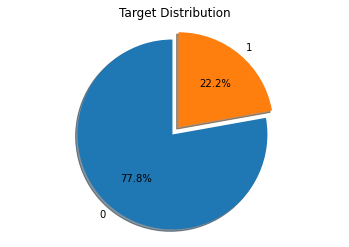

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig1, ax1 = plt.subplots()
ax1.pie(df_prepped['TARGET'].value_counts(), labels=['0', '1'], explode=(0, 0.1),
        autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Target Distribution')

plt.show()

### Correlation Analysis
It is important to check for multi-collinearity among features when doing regression analysis. The presence of collinear features detracts from the impact of those features. When dealing with highly collinear features, one of them should be removed.

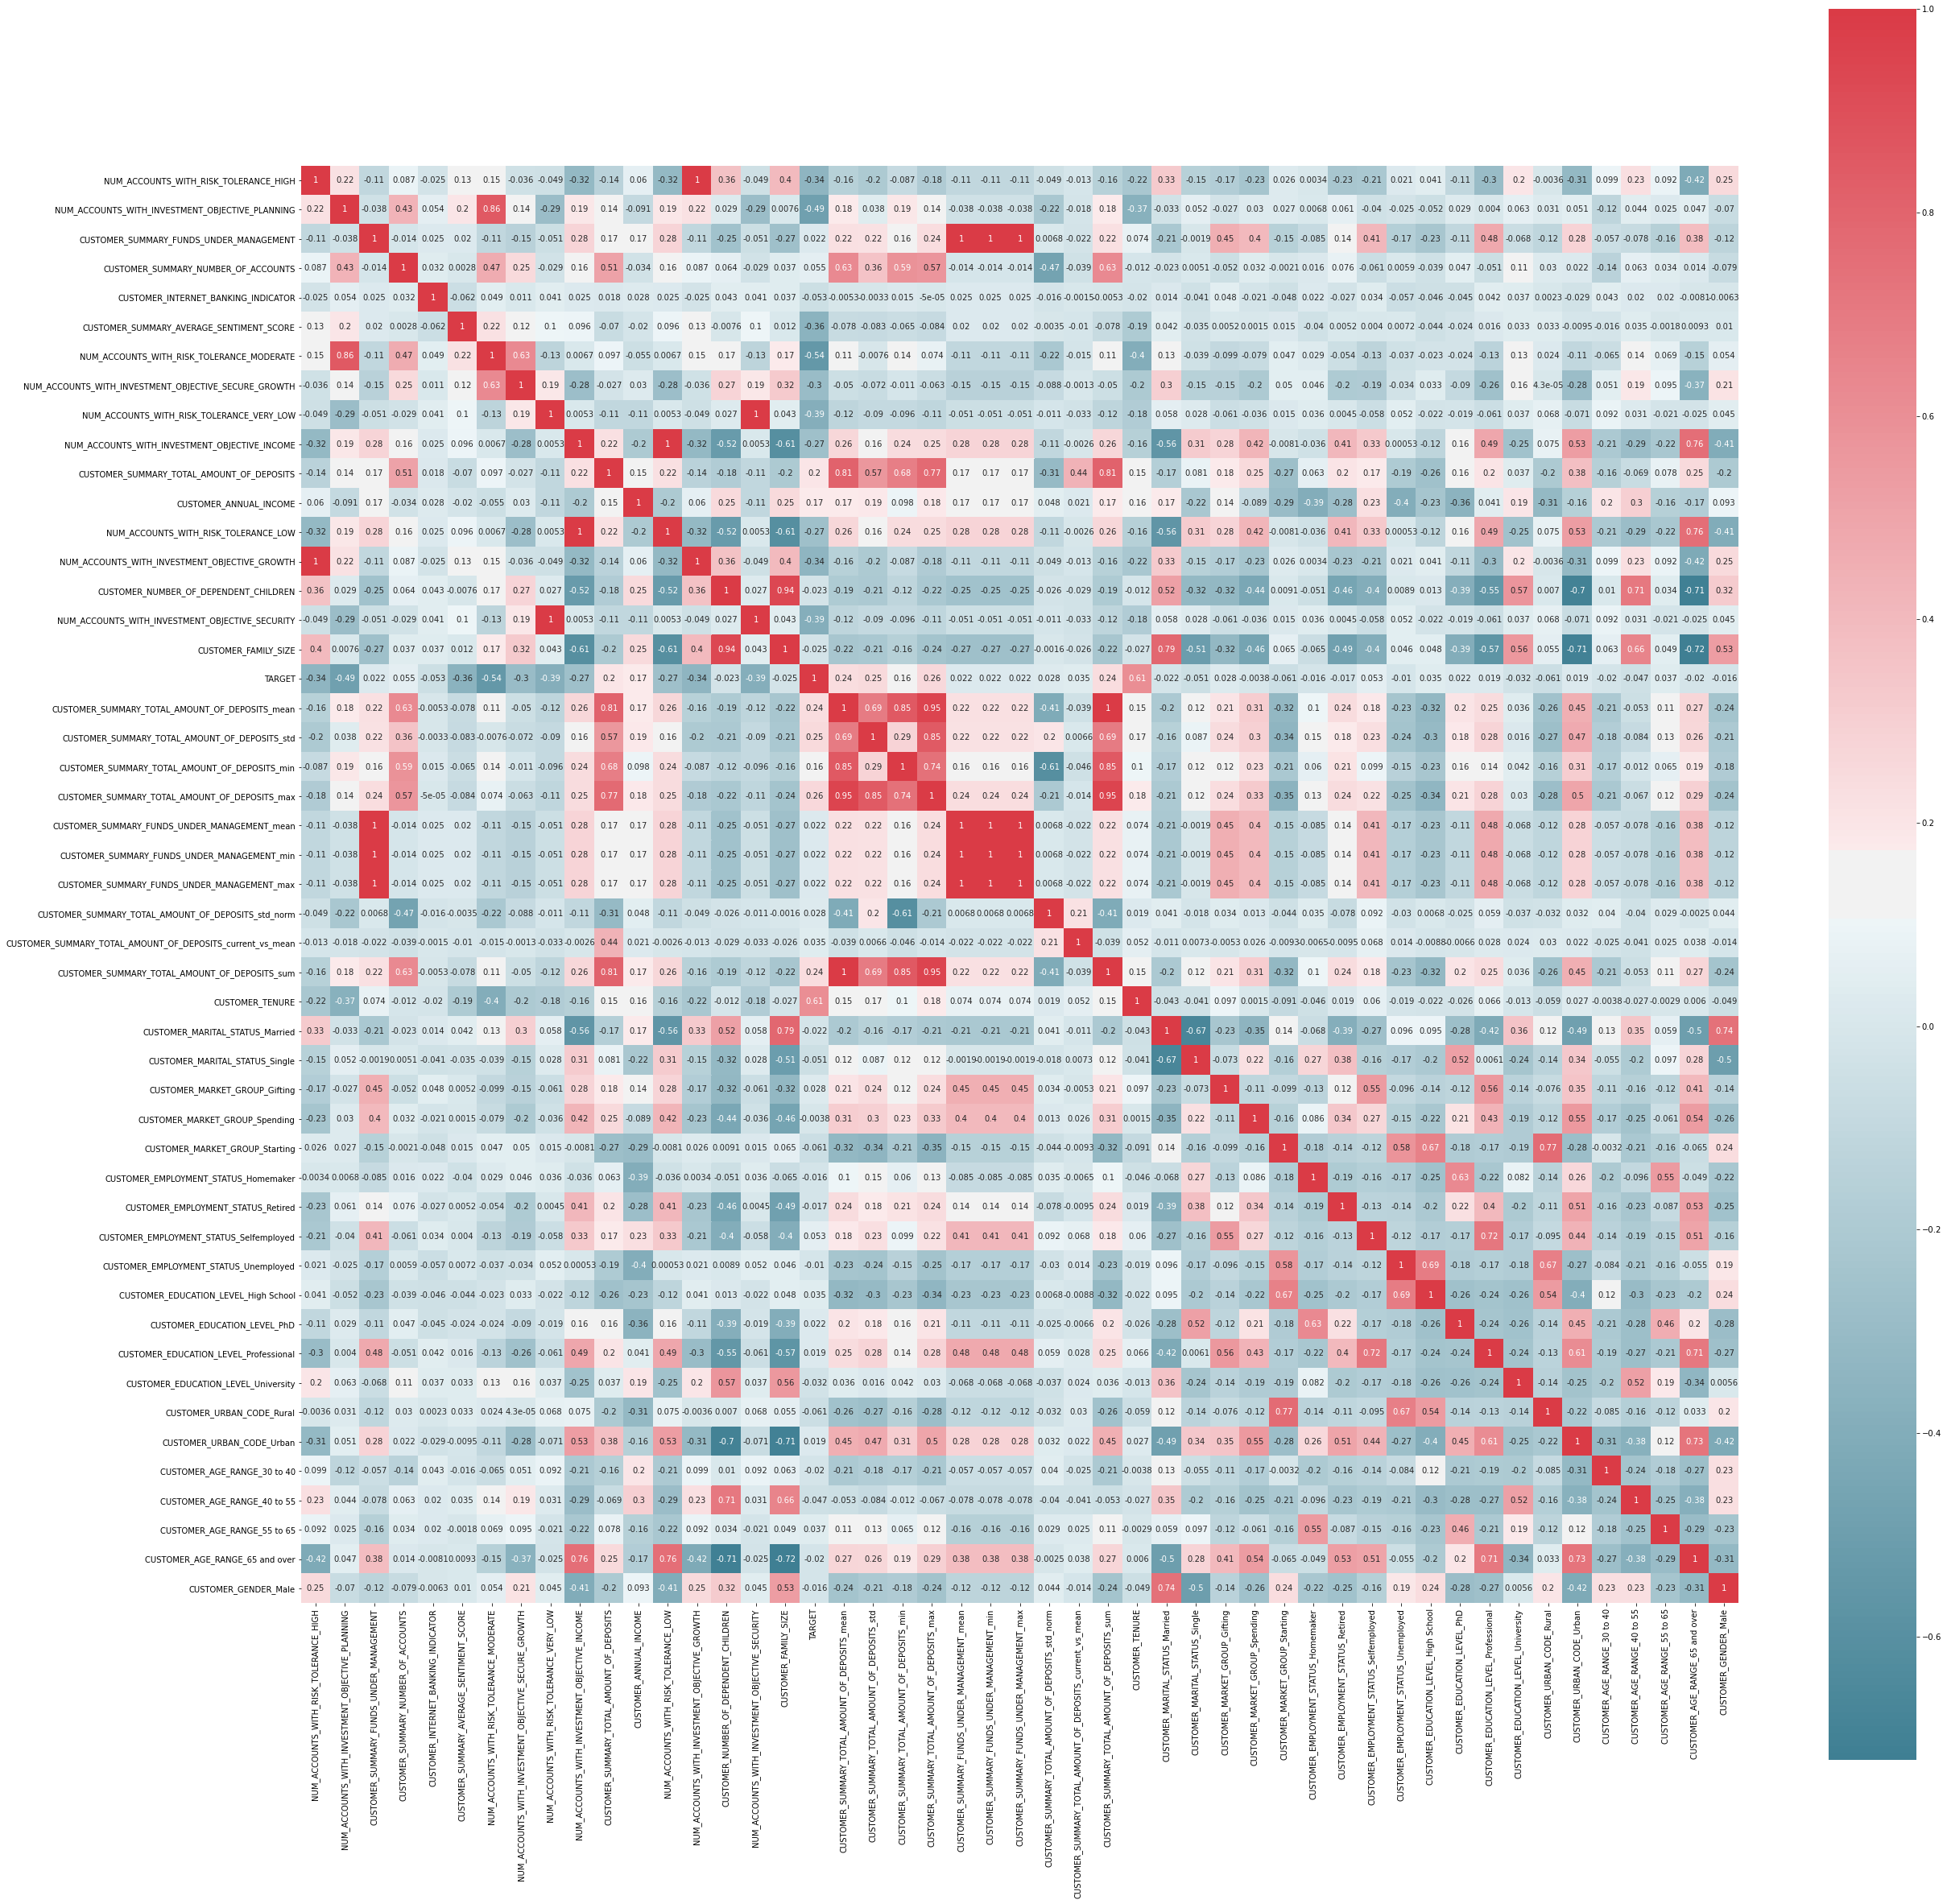

In [8]:
import seaborn as sns
%matplotlib inline

f, ax = plt.subplots(figsize=(40, 40))
corr = df_prepped.corr()
temp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax,annot=True)

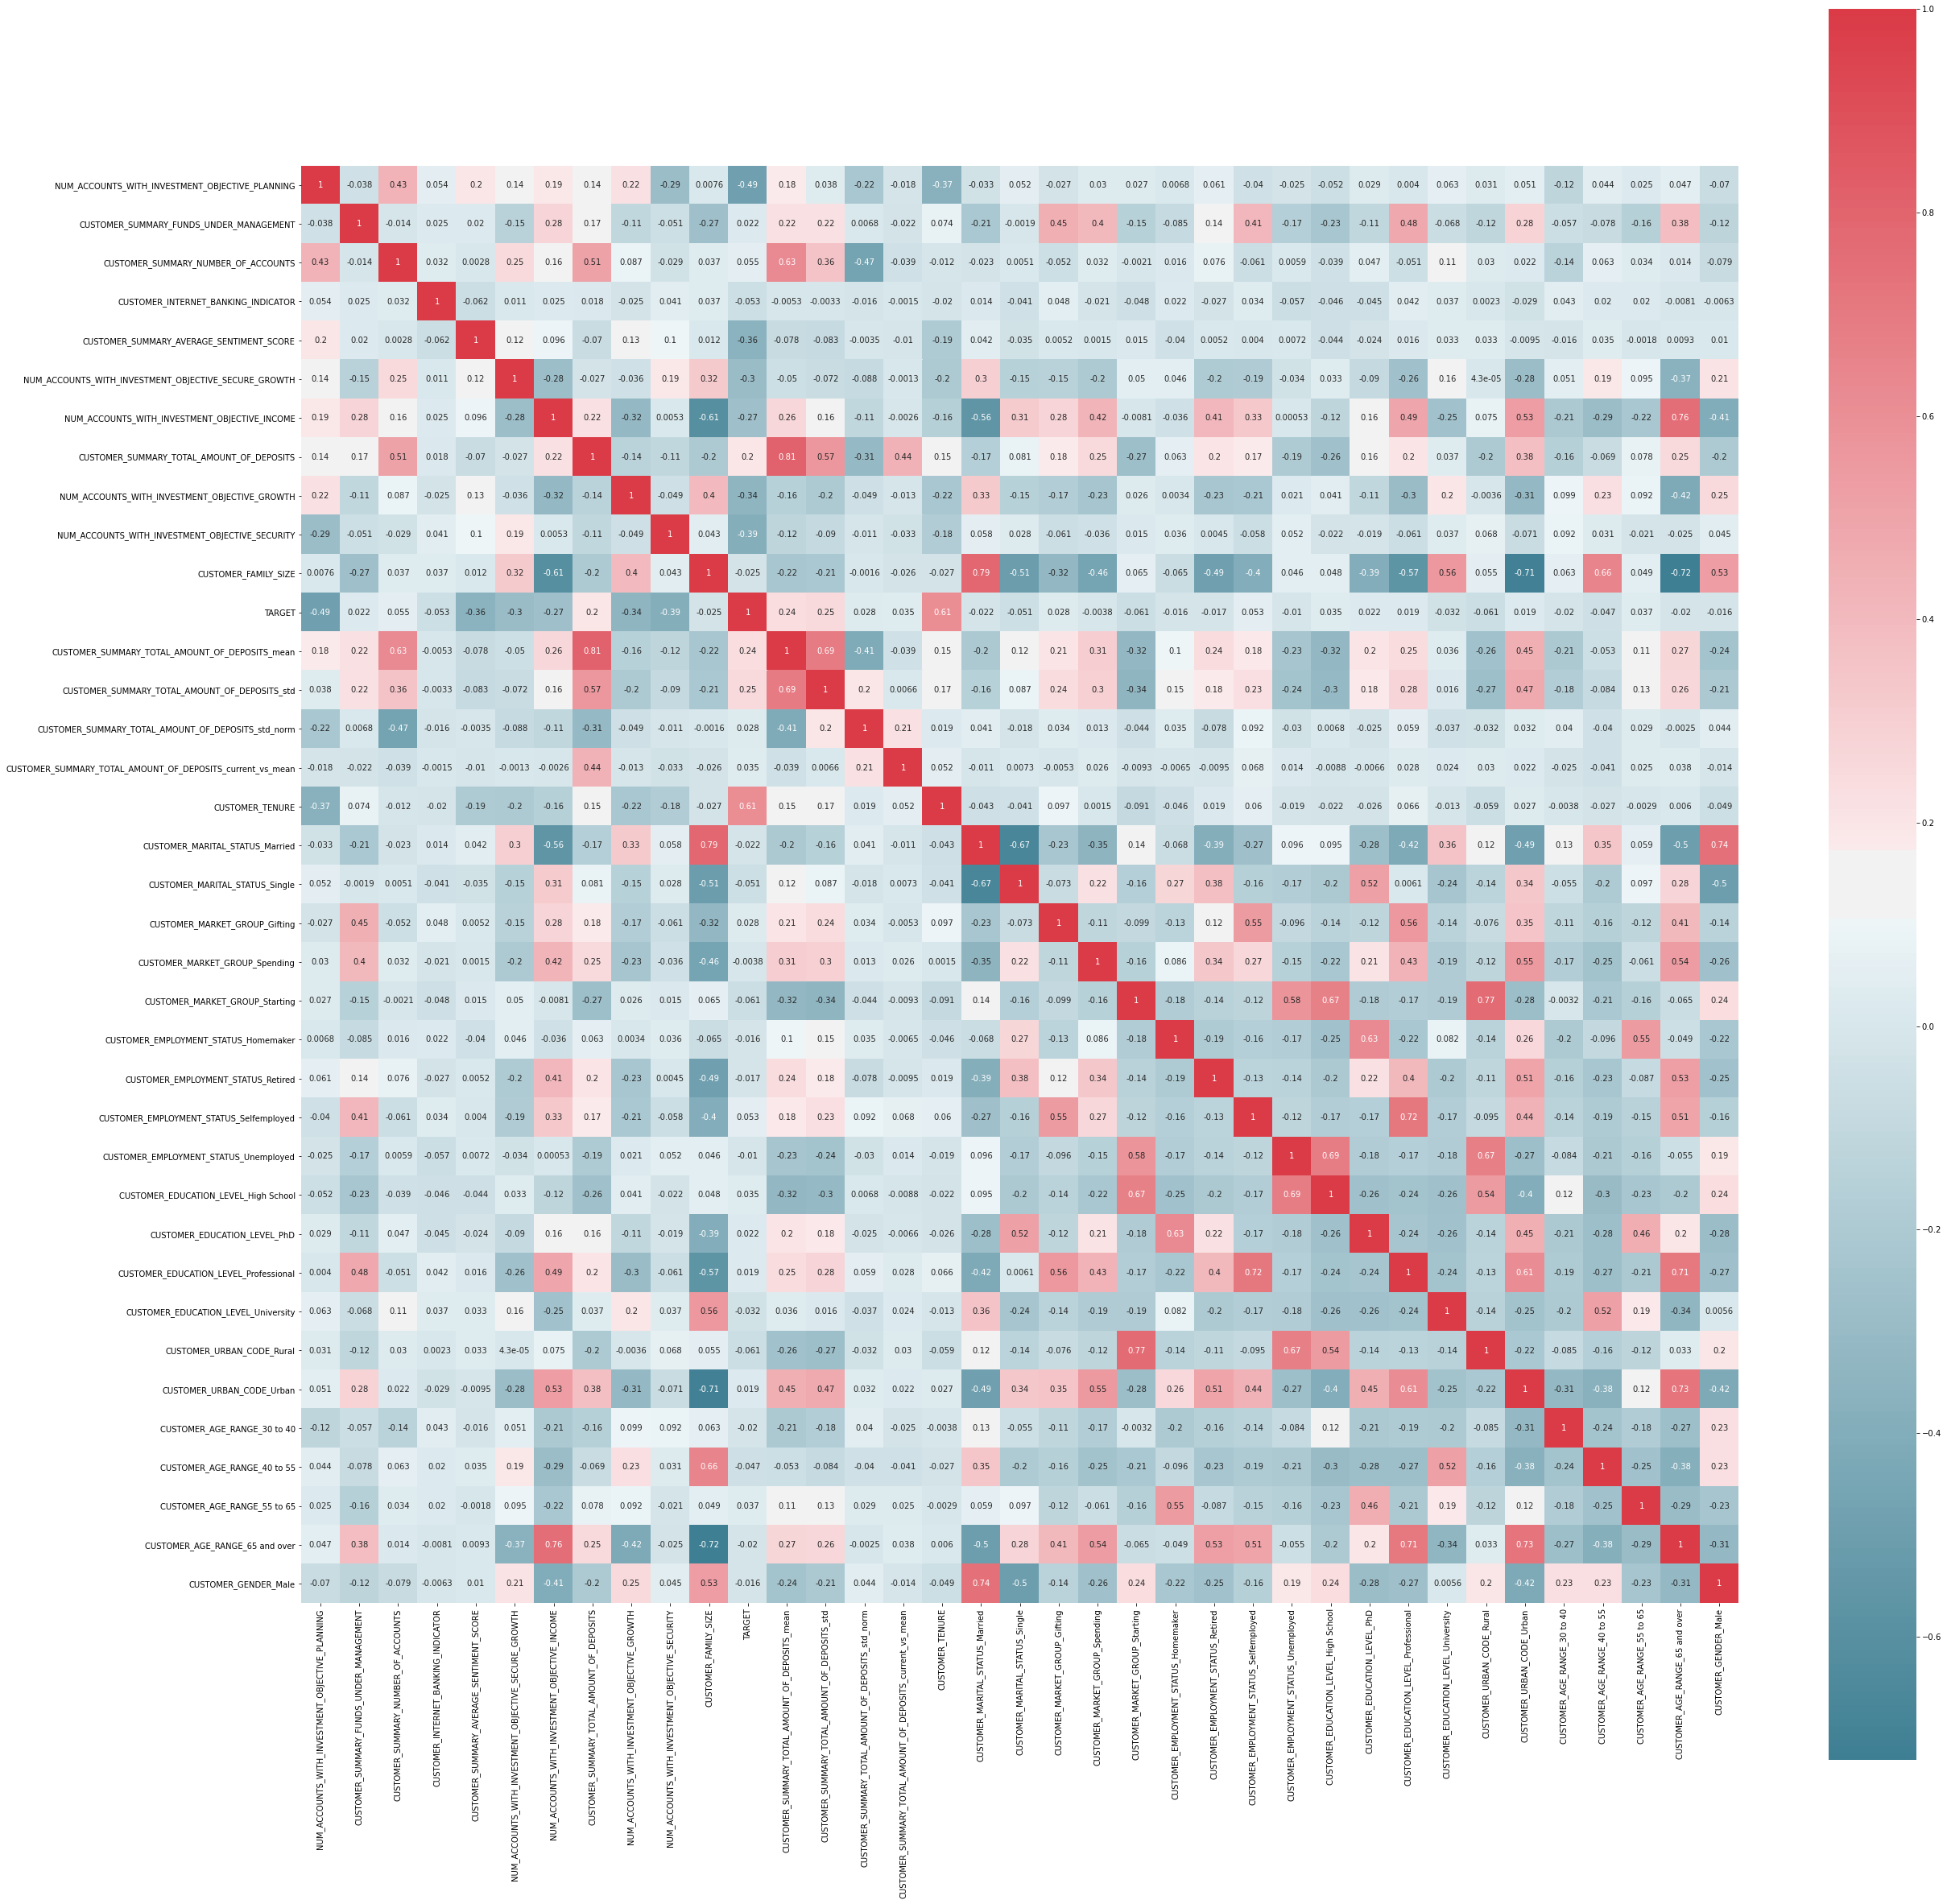

In [9]:
to_drop_corr = ['CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_mean', 'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_min',
           'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_max', 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_min',
           'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_max', 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_sum',
           'CUSTOMER_ANNUAL_INCOME', 'CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN',
           'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_MODERATE', 'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_HIGH',
           'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_VERY_LOW', 'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_LOW']

df_prepped = df_prepped.drop(to_drop_corr, axis=1)

f, ax = plt.subplots(figsize=(40,40))
corr = df_prepped.corr()
temp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax,annot=True)

### Display Prepared Data

Now that the data is ready for analysis, we will take a quick look at the dataset to ensure that everything is as expected.

In [10]:
print('\nTraining Data for Customer Attrition Use Case:')
display(df_prepped.head())
print("{} rows, {} columns\n".format(*df_prepped.shape))


Training Data for Customer Attrition Use Case:


,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_PLANNING,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT,CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS,CUSTOMER_INTERNET_BANKING_INDICATOR,CUSTOMER_SUMMARY_AVERAGE_SENTIMENT_SCORE,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURE_GROWTH,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_INCOME,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_GROWTH,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURITY,CUSTOMER_FAMILY_SIZE,TARGET,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_mean,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_std,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_std_norm,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_current_vs_mean,CUSTOMER_TENURE,CUSTOMER_MARITAL_STATUS_Married,CUSTOMER_MARITAL_STATUS_Single,CUSTOMER_MARKET_GROUP_Gifting,CUSTOMER_MARKET_GROUP_Spending,CUSTOMER_MARKET_GROUP_Starting,CUSTOMER_EMPLOYMENT_STATUS_Homemaker,CUSTOMER_EMPLOYMENT_STATUS_Retired,CUSTOMER_EMPLOYMENT_STATUS_Selfemployed,CUSTOMER_EMPLOYMENT_STATUS_Unemployed,CUSTOMER_EDUCATION_LEVEL_High School,CUSTOMER_EDUCATION_LEVEL_PhD,CUSTOMER_EDUCATION_LEVEL_Professional,CUSTOMER_EDUCATION_LEVEL_University,CUSTOMER_URBAN_CODE_Rural,CUSTOMER_URBAN_CODE_Urban,CUSTOMER_AGE_RANGE_30 to 40,CUSTOMER_AGE_RANGE_40 to 55,CUSTOMER_AGE_RANGE_55 to 65,CUSTOMER_AGE_RANGE_65 and over,CUSTOMER_GENDER_Male
0,0.0,750000.0,2,0,1,0.0,0.0,1417.080532,0.0,0.0,2,1,1205.895888,682.349564,0.565845,1.175127,20,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1
1,0.0,150000.0,3,0,0,0.0,0.0,766.447177,0.0,0.0,4,1,1083.573374,460.619376,0.425093,0.707333,19,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0.0,180000.0,3,0,0,0.0,0.0,1126.965752,0.0,0.0,2,1,1303.866785,323.284549,0.247943,0.864326,20,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
3,0.0,1250000.0,2,1,0,0.0,0.0,1172.303938,0.0,0.0,2,1,1291.962891,460.112704,0.356135,0.907382,20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.0,1250000.0,2,1,2,0.0,0.0,2235.962616,0.0,0.0,2,1,1793.042669,733.219060,0.408924,1.247021,21,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1


721 rows, 37 columns



In [11]:
to_drop_more = ['CUSTOMER_TENURE', 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_PLANNING',
                'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURITY']
df_prepped = df_prepped.drop(to_drop_more, axis=1)

### Save Prepared data
- We can save the prepared data in order to transfer the data to the model training notebook. This data will be called `training_data.csv`

In [12]:
project.save_data('training_data.csv', df_prepped.to_csv(index=False), overwrite=True)

{'file_name': 'training_data.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'customerattritionprediction-donotdelete-pr-imtru8kix45dl6',
 'asset_id': 'f64a2d3b-4b50-431d-8410-64fe339239e6'}

Now we have finished preparing the dataset and saved out the prepped data for modelling. See notebook `2-model-training` for the next step.

<hr>

Sample Materials, provided under <a href="https://github.com/IBM/Industry-Accelerators/blob/master/CPD%20SaaS/LICENSE" target="_blank" rel="noopener noreferrer">license.</a> <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2019, 2021. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>